## Import dependencies

In [ ]:
import torch
import torchvision
import os

using_colab=False

if using_colab:
    !pip install torchinfo
    os.environ["BASE_PATH"] = os.getcwd()
else:
    os.environ["BASE_PATH"] = os.path.dirname(os.getcwd())

print("BASE_PATH:", os.environ["BASE_PATH"])
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())

BASE_PATH: /home/sschwartz/Dokumente/ml_mcu_hs_25/giga-sam
PyTorch version: 2.9.1+cu128
Torchvision version: 0.24.1+cu128
CUDA is available: False


In [ ]:
%%bash

cd $BASE_PATH
CURL="curl -s -L -O"

# Download dataset
mkdir outputs > /dev/null 2>&1 && echo "✅ Output directory created" 
mkdir dataset > /dev/null 2>&1 && echo "✅ Dataset directory created" && cd dataset

if [ $? -eq 0 ]; then
  echo "Downloading COCO 2017 dataset and LVIS v1 validation annatations ..."
  $CURL http://images.cocodataset.org/zips/val2017.zip &
  $CURL http://images.cocodataset.org/zips/train2017.zip &
  $CURL http://images.cocodataset.org/annotations/annotations_trainval2017.zip &
  $CURL https://dl.fbaipublicfiles.com/LVIS/lvis_v1_val.json.zip &
  wait
  unzip -q val2017.zip && rm val2017.zip &
  unzip -q train2017.zip && rm train2017.zip &
  unzip -q annotations_trainval2017.zip && rm annotations_trainval2017.zip &
  wait
  echo "✅ Dataset successfully downloaded"
  cd ..
else
  echo "✅ Dataset already downloaded!"
fi

✅ Dataset already downloaded!


In [3]:
import os
import json
import numpy as np
from pycocotools.coco import COCO
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

### Define Model

In [4]:
class MinimalSam(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        def depthwise_conv(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, in_c, kernel_size=3, padding=1, groups=in_c, bias=False),
                nn.BatchNorm2d(in_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_c, out_c, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            )
        
        self.encoder_stage1 = depthwise_conv(in_channels, 48)
        self.down1 = nn.Conv2d(48, 48, kernel_size=3, stride=2, padding=1, bias=False)
        self.bottleneck = depthwise_conv(48, 96)
        self.up1 = nn.Sequential(nn.Upsample(scale_factor=2, mode="nearest"), depthwise_conv(96, 48))
        self.output_head = nn.Conv2d(48, 1, kernel_size=1)

    def forward(self, x):
        x = self.encoder_stage1(x)
        x = self.down1(x)
        x = self.bottleneck(x)
        x = self.up1(x)
        x = self.output_head(x)
        return x

In [5]:
class PicoSAM2(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        def depthwise_conv(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, in_c, kernel_size=3, padding=1, groups=in_c, bias=False),
                nn.BatchNorm2d(in_c),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_c, out_c, kernel_size=1, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True),
            )

        self.encoder_stage1 = depthwise_conv(in_channels, 48)
        self.down1 = nn.Conv2d(48, 48, kernel_size=3, stride=2, padding=1, bias=False)
        self.encoder_stage2 = depthwise_conv(48, 96)
        self.down2 = nn.Conv2d(96, 96, kernel_size=3, stride=2, padding=1, bias=False)
        self.encoder_stage3 = depthwise_conv(96, 160)
        self.down3 = nn.Conv2d(160, 160, kernel_size=3, stride=2, padding=1, bias=False)
        self.encoder_stage4 = depthwise_conv(160, 256)
        self.down4 = nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1, bias=False)

        self.bottleneck = depthwise_conv(256, 320)

        self.up1 = nn.Sequential(nn.Upsample(scale_factor=2, mode="nearest"), depthwise_conv(320, 192))
        self.skip_conn4 = nn.Conv2d(256, 192, kernel_size=1)

        self.up2 = nn.Sequential(nn.Upsample(scale_factor=2, mode="nearest"), depthwise_conv(192, 128))
        self.skip_conn3 = nn.Conv2d(160, 128, kernel_size=1)

        self.up3 = nn.Sequential(nn.Upsample(scale_factor=2, mode="nearest"), depthwise_conv(128, 80))
        self.skip_conn2 = nn.Conv2d(96, 80, kernel_size=1)

        self.up4 = nn.Sequential(nn.Upsample(scale_factor=2, mode="nearest"), depthwise_conv(80, 40))
        self.skip_conn1 = nn.Conv2d(48, 40, kernel_size=1)

        self.output_head = nn.Conv2d(40, 1, kernel_size=1)

    def forward(self, x):
        feat1 = self.encoder_stage1(x)
        feat2 = self.encoder_stage2(self.down1(feat1))
        feat3 = self.encoder_stage3(self.down2(feat2))
        feat4 = self.encoder_stage4(self.down3(feat3))
        bottleneck_out = self.bottleneck(self.down4(feat4))

        upsample1 = self.up1(bottleneck_out) + self.skip_conn4(feat4)
        upsample2 = self.up2(upsample1) + self.skip_conn3(feat3)
        upsample3 = self.up3(upsample2) + self.skip_conn2(feat2)
        upsample4 = self.up4(upsample3) + self.skip_conn1(feat1)

        return self.output_head(upsample4)

In [6]:
from torchinfo import summary

model = MinimalSam()
summary(model)

Layer (type:depth-idx)                   Param #
MinimalSam                               --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       27
│    └─BatchNorm2d: 2-2                  6
│    └─ReLU: 2-3                         --
│    └─Conv2d: 2-4                       144
│    └─BatchNorm2d: 2-5                  96
│    └─ReLU: 2-6                         --
├─Conv2d: 1-2                            20,736
├─Sequential: 1-3                        --
│    └─Conv2d: 2-7                       432
│    └─BatchNorm2d: 2-8                  96
│    └─ReLU: 2-9                         --
│    └─Conv2d: 2-10                      4,608
│    └─BatchNorm2d: 2-11                 192
│    └─ReLU: 2-12                        --
├─Sequential: 1-4                        --
│    └─Upsample: 2-13                    --
│    └─Sequential: 2-14                  --
│    │    └─Conv2d: 3-1                  864
│    │    └─BatchNorm2d: 3-2             192
│    │    └─ReLU

### Define Dataset

In [7]:
class MinimalSamDataset(Dataset):
    def __init__(self, annotation_file: str, img_dir: str, img_size: int, filter=False):
        super().__init__()

        self.img_dir = img_dir
        self.img_size = img_size
        
        self.coco = COCO(annotation_file)
        self.anns = [ann for ann in self.coco.loadAnns(self.coco.getAnnIds()) if ann.get("iscrowd", 0) == 0]

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]), # mean and std of ImageNet
        ])

        if not filter:
            # load from json file
            with open("filtered_anns.json", "r") as f:
                self.filtered_anns = json.load(f)
            return
        
        # === Pre-filtering annotations without valid mask ===
        self.count_no_mask = 0 #8
        self.count_center_not_in_mask = 0 #106336
        self.count_invalid_crop = 0 #115905
        self.count_high_mask_area = 0 #175600
        
        self.filtered_anns = []

        for ann in tqdm(self.anns):
            mask = self.coco.annToMask(ann)

            ys, xs = np.where(mask > 0)
            
            # does mask exist?
            if len(xs) == 0:
                self.count_no_mask += 1
                continue

            min_x, max_x = xs.min(), xs.max()
            min_y, max_y = ys.min(), ys.max()
            mask_center_x = (min_x + max_x) // 2
            mask_center_y = (min_y + max_y) // 2

            # is center in mask?
            if not mask[mask_center_y, mask_center_x]:
                self.count_center_not_in_mask += 1
                continue

            center_x, center_y = mask_center_x, mask_center_y
            
            # define crop box
            left = center_x - self.img_size // 2
            top  = center_y - self.img_size // 2
            right  = left + self.img_size
            bottom = top + self.img_size

            # check if crop box is valid
            if left < 0 or top < 0 or right > mask.shape[1] or bottom > mask.shape[0]:
                self.count_invalid_crop += 1
                continue

            # check if the cropped mask area occupies more than 60% of the crop area
            crop_area = self.img_size * self.img_size
            mask_area = np.sum(mask[top:bottom, left:right] > 0)
            if mask_area / crop_area > 0.6:
                self.count_high_mask_area += 1
                continue

            self.filtered_anns.append(ann)

    def __len__(self):
        return len(self.filtered_anns)
    
    def __getitem__(self, index):
        ann = self.filtered_anns[index]
        img_id = ann['image_id']
        img = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img['file_name'])

        image = Image.open(img_path).convert("RGB")
        mask = self.coco.annToMask(ann)

        cropped_image, cropped_mask = self._crop(image, mask)

        image_tensor = self.transform(cropped_image)
        mask_tensor = torch.tensor(np.array(cropped_mask), dtype=torch.float32).unsqueeze(0) # why unsqueeze??

        return image_tensor, mask_tensor
    
    def _crop(self, image, mask):
        ys, xs = np.where(mask > 0)
        
        min_x, max_x = xs.min(), xs.max()
        min_y, max_y = ys.min(), ys.max()
        mask_center_x = (min_x + max_x) // 2
        mask_center_y = (min_y + max_y) // 2

        center_x, center_y = mask_center_x, mask_center_y

        # define crop box
        left = center_x - self.img_size // 2
        top  = center_y - self.img_size // 2
        right  = left + self.img_size
        bottom = top + self.img_size

        # could leave out resizing here 
        cropped_img = image.crop((left, top, right, bottom)).resize((self.img_size, self.img_size), Image.Resampling.LANCZOS)
        cropped_mask = Image.fromarray(mask[top:bottom, left:right]).resize((self.img_size, self.img_size), Image.Resampling.LANCZOS)

        return cropped_img, cropped_mask  #, center_x, center_y, left, top

### Define loss functions & performance metrics

In [8]:
def bce_dice_loss(pred_mask, gt_mask):
    pred_mask = torch.sigmoid(pred_mask)
    # idea: bce = F.binary_cross_entropy_with_logits(pred_mask, gt_mask)
    bce = F.binary_cross_entropy(pred_mask, gt_mask)
    intersection = (pred_mask * gt_mask).sum(dim=(1, 2, 3))
    union = pred_mask.sum(dim=(1, 2, 3)) + gt_mask.sum(dim=(1, 2, 3))
    dice = 1 - ((2 * intersection + 1e-6) / (union + 1e-6)).mean()
    return bce + dice

def compute_iou(pred_mask, target_mask):
    pred_binary = (torch.sigmoid(pred_mask) > 0.5).cpu().numpy()
    target_binary = (torch.sigmoid(target_mask) > 0.5).cpu().numpy()

    intersection = np.logical_and(pred_binary, target_binary).sum()
    union = np.logical_or(pred_binary, target_binary).sum()
    return intersection / union if union > 0 else 1.0

### Train model

In [ ]:
# setup model and database
annotation_file = os.path.join(os.environ["BASE_PATH"], "dataset/annotations/instances_train2017.json")
img_dir = os.path.join(os.environ["BASE_PATH"], "dataset/train2017")
img_size = 96

LEARNING_RATE = 3e-4
NUM_EPOCHS = 1
BATCH_SIZE = 8
OUTPUT_DIR = os.path.join(os.environ["BASE_PATH"], "outputs")

def train():
    wandb.init(project="PicoSAM2-scratch", config={"img_size": img_size, "epochs": NUM_EPOCHS})
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = PicoSAM2().to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lambda step: min(1.0, step / 1000))

    dataset = MinimalSamDataset(annotation_file, img_dir, img_size, filter=True)
    train_len = int(len(dataset) * 0.95)
    train_ds, val_ds = random_split(dataset, [train_len, len(dataset) - train_len])
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)

    for epoch in range(NUM_EPOCHS):
        model.train()

        # logging
        total_loss, total_iou, samples = 0, 0, 0


        for batch_idx, (images, masks) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1} - Train")):
            images, masks = images.to(device), masks.to(device)

            preds = model(images)
            loss = bce_dice_loss(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            # logging
            batch_iou = compute_iou(preds, masks)
            wandb.log({"batch_loss": loss.item(), "batch_mIoU": batch_iou, "epoch": epoch + 1})

            total_loss += loss.item() * images.size(0)
            total_iou += batch_iou * images.size(0)
            samples += images.size(0)

        wandb.log({"train_loss": total_loss / samples, "train_mIoU": total_iou / samples, "epoch": epoch + 1})

        model.eval()
        val_loss, val_iou, val_samples = 0, 0, 0
        with torch.no_grad():
            for images, masks, _, _ in tqdm(val_loader, desc=f"Epoch {epoch + 1} - Val"):
                images, masks = images.to(device), masks.to(device)
                preds = model(images)
                loss = bce_dice_loss(preds, masks)
                val_loss += loss.item() * images.size(0)
                val_iou += compute_iou(preds, masks) * images.size(0)
                val_samples += images.size(0)

        wandb.log({"val_loss": val_loss / val_samples, "val_mIoU": val_iou / val_samples, "epoch": epoch + 1})

        torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, f"PicoSAM2_epoch{epoch + 1}.pt"))

In [ ]:
train()

### Inference

In [11]:
def unnormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return (tensor * std + mean).clamp(0,1)

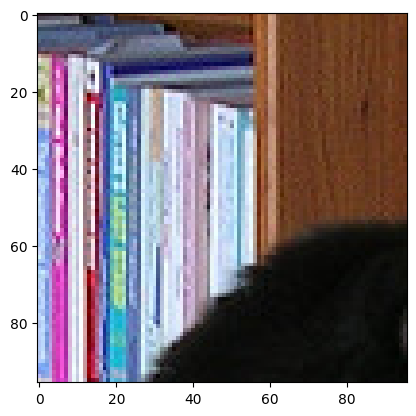

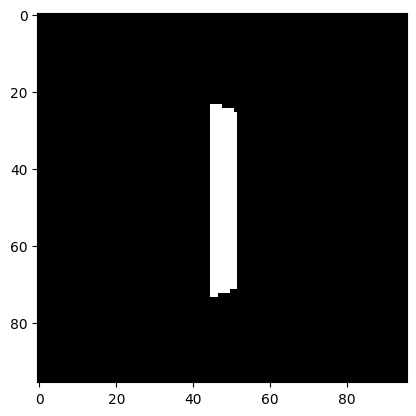

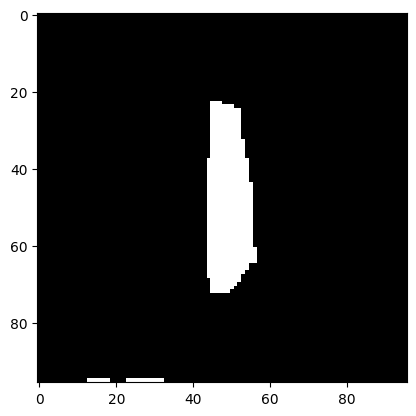

In [ ]:
# bad: 70
image, mask = dataset.__getitem__(11130)

model = PicoSAM2()
model.load_state_dict(torch.load(os.path.join(os.environ["BASE_PATH"], "checkpoints", "PicoSAM2_epoch1.pt"), map_location="cpu"))
model.eval()

with torch.no_grad():
    pred_mask = model(image.unsqueeze(0))
    pred_mask = (torch.sigmoid(pred_mask) > 0.5).float().squeeze(0)

image = unnormalize(image)

plt.imshow(image.permute(1, 2, 0))
plt.show()
plt.imshow(mask.squeeze(0), cmap='gray')
plt.show()
plt.imshow(pred_mask.squeeze(0), cmap='gray')
plt.show()